In [2]:
from tdc.single_pred import ADME
from DeepPurpose.utils import *
from DeepPurpose import CompoundPred
from tdc import Evaluator
from deepchem import deepchem
import xgboost
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import pandas as pd

# Experiments

In [3]:
def BenchmarkModels(data_name: str, evaluator_name: str, classification: bool):
    """Function to train and test MPNN, Transform and XGBoost on a TDC ADME dataset specified by data_name.
    The evaluator_name specifies which evalution metric to use and the classification boolean specfies whether to
    build an XGBoost classification or regression model"""
    
    data = ADME(name = data_name)
    # The scaffold split forces training and test set have distant molecular structures. This is done to try and
    # replicate the real-world where drug structures evolve over time
    split = data.get_split(method = 'scaffold')
    evaluator = Evaluator(name = evaluator_name)
    
    drug_encodings = ['MPNN','Transformer']
    scores = {}

    # For MPNN and transformer encodings, the below formats the data to be compatiable with the DeepPurpose library.
    # The models are then trained using default parameters, tested and evaluated
    for drug_encoding in drug_encodings:
        train = data_process(X_drug = split['train'].Drug.values, y = split['train'].Y.values, 
                    drug_encoding = drug_encoding,
                    split_method='no_split')

        val = data_process(X_drug = split['valid'].Drug.values, y = split['valid'].Y.values, 
                    drug_encoding = drug_encoding,
                    split_method='no_split')

        test = data_process(X_drug = split['test'].Drug.values, y = split['test'].Y.values, 
                    drug_encoding = drug_encoding,
                    split_method='no_split')

        config = generate_config(drug_encoding = drug_encoding)
        model = CompoundPred.model_initialize(**config)
        model.train(train, val, test, verbose = False)
        y_pred = model.predict(test)
        score = evaluator(split['test'].Y.values, y_pred)
        scores[drug_encoding] = score
    
    # The MACCS fingerprint is used as the feature descriptor to input into the XGBoost model as it is relatively
    # small compared to other popular fingerprints
    maccskeys = deepchem.feat.MACCSKeysFingerprint()
    maccs_train = maccskeys.featurize(split['train'].Drug.values)
    # The validation set isn't used as we do no hyperparamter tuning on any of the models to keep comparisons fair.
    # For a fair comparison we also do not use it to train the models
    maccs_valid = maccskeys.featurize(split['valid'].Drug.values)
    maccs_test = maccskeys.featurize(split['test'].Drug.values)
    
    # Use XGBoost regressor for regression tasks and XGBoost classifier for classification tasks
    xgb = xgboost.XGBClassifier(tree_method='exact') if classification else xgboost.XGBRegressor(tree_method='exact')
    xgb.fit(maccs_train, split['train'].Y.values)
    
    pred_xgb = xgb.predict(maccs_test)
    score = evaluator(split['test'].Y.values, pred_xgb)
    scores['XGBoost'] = score
    
    return scores
    

### Absorption Model

Lipophilicity, AstraZeneca dataset was used along with the recommended evaluation metric: MAE

Note: Lipophilicity, AstraZeneca is the second largest dataset after Solubility, AqSolDB, however Solubility, AqSolDB
failed the DeepPurpose data_process method (this can be seen in the Rough.ipynb file).

In [4]:
abs_scores = BenchmarkModels('Lipophilicity_AstraZeneca', 'MAE', classification = False)

Found local copy...
Loading...
Done!
100%|█████████████████████████████████████| 4200/4200 [00:02<00:00, 2062.56it/s]


Drug Property Prediction Mode...
in total: 2940 drugs
encoding drug...
unique drugs: 2940
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 420 drugs
encoding drug...
unique drugs: 420
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 840 drugs
encoding drug...
unique drugs: 840
do not do train/test split on the data for already splitted data
predicting...
Drug Property Prediction Mode...
in total: 2940 drugs
encoding drug...
unique drugs: 2940
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 420 drugs
encoding drug...
unique drugs: 420
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 840 drugs
encoding drug...
unique drugs: 840
do not do train/test split on the data for already splitted data
predicting...


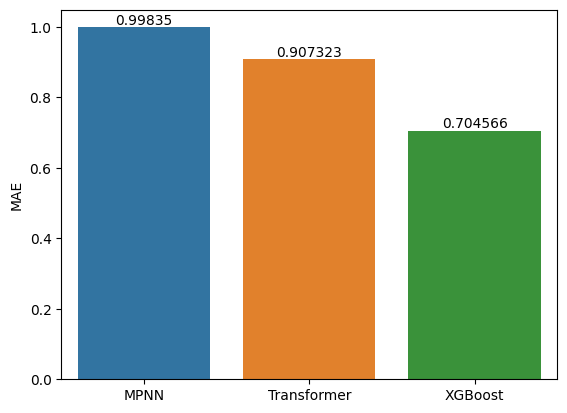

In [12]:
abs_score_df = pd.DataFrame.from_dict(abs_scores, orient = 'index', columns = ['MAE'])
ax = sns.barplot(abs_score_df, x = abs_score_df.index, y = 'MAE')
for i in ax.containers:
    ax.bar_label(i,)

### Distribution

BBB (Blood-Brain Barrier), Martins et al. dataset was used along with the recommended evaluation metric: AUROC

In [6]:
dist_scores = BenchmarkModels('BBB_Martins', 'ROC-AUC', classification = True)

Found local copy...
Loading...
Done!
100%|█████████████████████████████████████| 2030/2030 [00:00<00:00, 2396.17it/s]


Drug Property Prediction Mode...
in total: 1421 drugs
encoding drug...
unique drugs: 1383
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 203 drugs
encoding drug...
unique drugs: 198
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 406 drugs
encoding drug...
unique drugs: 394
do not do train/test split on the data for already splitted data
predicting...
Drug Property Prediction Mode...
in total: 1421 drugs
encoding drug...
unique drugs: 1383
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 203 drugs
encoding drug...
unique drugs: 198
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 406 drugs
encoding drug...
unique drugs: 394
do not do train/test split on the data for already splitted data
predicting...


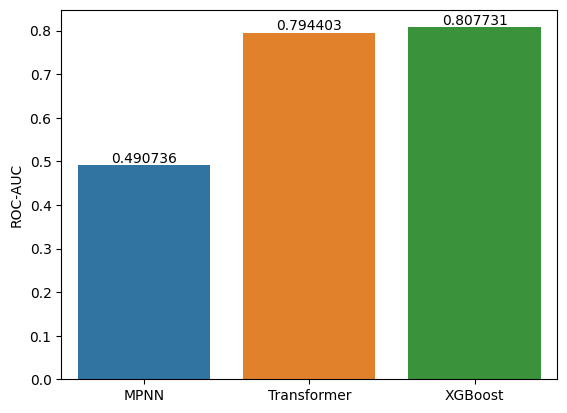

In [7]:
dist_score_df = pd.DataFrame.from_dict(dist_scores, orient = 'index', columns = ['ROC-AUC'])
ax = sns.barplot(dist_score_df, x = dist_score_df.index, y = 'ROC-AUC')
for i in ax.containers:
    ax.bar_label(i,)

### Metabolism

CYP P450 2D6 Inhibition, Veith et al. dataset was used along with the recommended evaluation metric: AUPRC

In [8]:
meta_scores = BenchmarkModels('CYP2D6_Veith', 'PR-AUC', classification = True)

Found local copy...
Loading...
Done!
100%|███████████████████████████████████| 13130/13130 [00:05<00:00, 2350.48it/s]


Drug Property Prediction Mode...
in total: 9191 drugs
encoding drug...
unique drugs: 9191
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 1313 drugs
encoding drug...
unique drugs: 1313
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 2626 drugs
encoding drug...
unique drugs: 2626
do not do train/test split on the data for already splitted data
predicting...
Drug Property Prediction Mode...
in total: 9191 drugs
encoding drug...
unique drugs: 9191
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 1313 drugs
encoding drug...
unique drugs: 1313
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 2626 drugs
encoding drug...
unique drugs: 2626
do not do train/test split on the data for already splitted data
predicting...


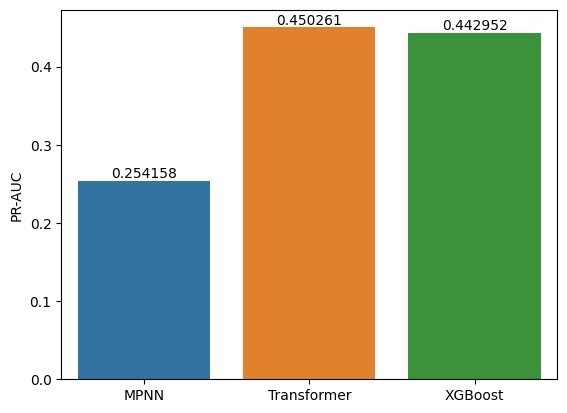

In [9]:
meta_score_df = pd.DataFrame.from_dict(meta_scores, orient = 'index', columns = ['PR-AUC'])
ax = sns.barplot(meta_score_df, x = meta_score_df.index, y = 'PR-AUC')
for i in ax.containers:
    ax.bar_label(i,)

### Metabolism

Clearance, AstraZeneca dataset was used along with the recommended evaluation metric: Spearman

In [10]:
excr_scores = BenchmarkModels('Clearance_Microsome_AZ', 'Spearman', classification = False)

Found local copy...
Loading...
Done!
100%|█████████████████████████████████████| 1102/1102 [00:00<00:00, 1880.05it/s]


Drug Property Prediction Mode...
in total: 771 drugs
encoding drug...
unique drugs: 771
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 110 drugs
encoding drug...
unique drugs: 110
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 221 drugs
encoding drug...
unique drugs: 221
do not do train/test split on the data for already splitted data
predicting...
Drug Property Prediction Mode...
in total: 771 drugs
encoding drug...
unique drugs: 771
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 110 drugs
encoding drug...
unique drugs: 110
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 221 drugs
encoding drug...
unique drugs: 221
do not do train/test split on the data for already splitted data
predicting...


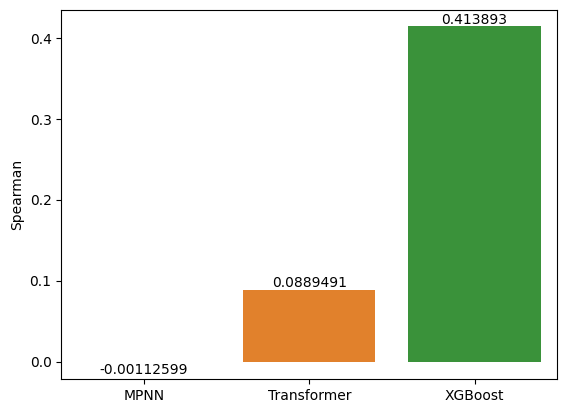

In [11]:
excr_score_df = pd.DataFrame.from_dict(excr_scores, orient = 'index', columns = ['Spearman'])
ax = sns.barplot(excr_score_df, x = excr_score_df.index, y = 'Spearman')
for i in ax.containers:
    ax.bar_label(i,)

# Results for Sales Team

Along with the visualisation of the results above, below are the results from benchmarking the performances of supervised graph neural networks, transformer models, and classical tree models on predicting ADME properites of small molecules.

In order to determine the general ability of the model's ADME predictive power, each model was trained on a dataset corresponding to each of the properties making up the ADME acroynm (4 datasets per model). To further evaluate generalisation to ADME properties, the datasets were chosen to include 2 regression tasks (absorption and excretion), and 2 classification tasks (distribution and metabolism). The specific dataset within each ADME class from the Therapeutics Data Commons was chosen to be the one with largest number of samples.

A 70/30 train-validation-test split was used to train and evaulate the models. The results show the performance of the models on each of the datasets. The evaluation metric for each dataset corresponds to the recommended metric for the dataset by the Therapeutics Data Commons - this will help to compare the models with other models in literature that use the same datasets.

**Absorption - MAE:** \
'MPNN': 0.9983504806416373 **3rd** \
'Transformer': 0.907322991992746 **2nd** \
'XGBoost': 0.704565932706708 **1st**

**Distribution - AUROC:** \
'MPNN': 0.4907363977485929 **3rd** \
'Transformer': 0.7944027517198249 **2nd** \
'XGBoost': 0.8077313946216386 **1st**

**Metabolism - AUPRC:** \
'MPNN': 0.25415805112405554 **3rd** \
'Transformer': 0.4502612698810132 **1st** \
'XGBoost': 0.4429516180818023 **2nd**

**Excretion - Spearman:** \
'MPNN': -0.0011259914958362681 **3rd** \
'Transformer': 0.0889491168009243 **2nd** \
'XGBoost': 0.41389315265077803 **1st**

The results show that across all datasets the XGBoost was always a high performer - ranking first in 3 out of 4 of the datasets and a very close second in the metabolism dataset. The MPNN performed significantly worse across all datasets compared to the other two models. The overall performance of the models can be calculated as a rank corresponding to positions the models came in terms of performance for each of the dataset.

**1st:** XGBoost\
**2nd:** Transformer\
**3rd:** MPNN

The developer recommends the sales team to use the above findings to close the deal as it will help to illustrate the superiority of the DeepMirror platform across a variety ADME properties and datasets once trained and tested in the same way

However, if the client requests only one dataset/evalutation metric, the developer recommends the absorption dataset (Lipophilicity, AstraZeneca ) as the it is a good summary of the overall performance and the evaluation metric is the most intuitative to a non-technnical person.

